## Converting JSON to dataframe

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import nltk
nltk.download('punkt')

# Load JSON data
with open('/Users/armaanhaque/Documents/NLP project/all_reviews.json', 'r') as file:
    data = json.load(file)

# Flatten the list of lists
flattened_data = [entry for sublist in data for entry in sublist]

# Convert to DataFrame
df = pd.DataFrame(flattened_data)

# Reorder or select specific columns if needed
columns = ["course_id","professor", "department", "Quality", "Difficulty", "Comment"]
df = df[columns]
df['S.no'] = range(1, len(df) + 1)

# If you want the serial number to be the first column
df = df[['S.no'] + [col for col in df.columns if col != 'S.no']]


# Display the DataFrame
df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/armaanhaque/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,S.no,course_id,professor,department,Quality,Difficulty,Comment
0,1,FHS010,James Nichols,Government department,5.0,2.0,Professor Nichols is super nice and very whole...
1,2,FHS010,James Nichols,Government department,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,3,POLPHILOSOPHY,James Nichols,Government department,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,4,FHS010,James Nichols,Government department,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5,FHS10,James Nichols,Government department,5.0,1.0,Good Professor. Really nice and encouraging te...


In [2]:
df["Comment"].values[0]

"Professor Nichols is super nice and very wholesome! There is a lot of reading, but you can get by without doing very much of it. He does talk a LOT and doesn't foster as much discussion, but I think the latter might also be because people stop doing the readings a few weeks in. He does appreciate participation and gives great essay feedback!"

## Quick EDA

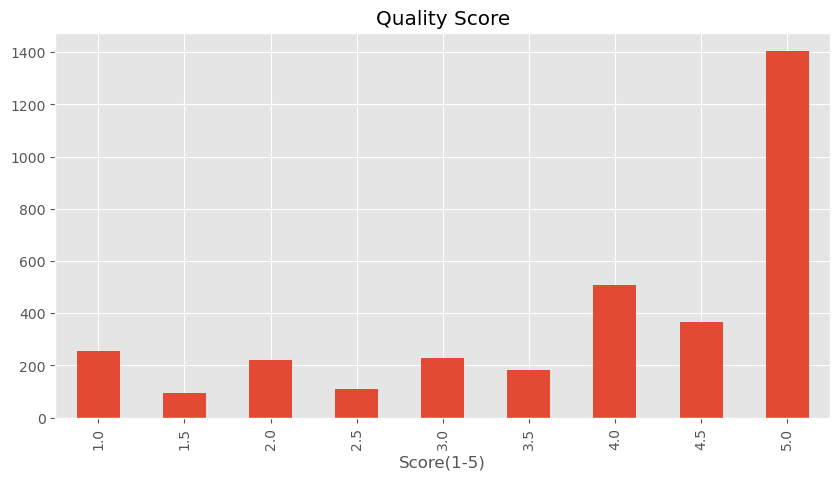

In [3]:
ax = df['Quality'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Quality Score',
          figsize=(10, 5))
ax.set_xlabel('Score(1-5)')
plt.show()

## Basic NLTK

In [4]:
example = df['Comment'][24]
print(example)

Took her freshman class.  Very interesting. papers were the only grade and shes a fairly good grader.  I would take her if you have the chance.  work load is reasonable


In [5]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
tokens = nltk.word_tokenize(example)
tokens[:35]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/armaanhaque/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/armaanhaque/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/armaanhaque/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/armaanhaque/nltk_data...
[nltk_data]   Package words is already up-to-date!


['Took',
 'her',
 'freshman',
 'class',
 '.',
 'Very',
 'interesting',
 '.',
 'papers',
 'were',
 'the',
 'only',
 'grade',
 'and',
 'shes',
 'a',
 'fairly',
 'good',
 'grader',
 '.',
 'I',
 'would',
 'take',
 'her',
 'if',
 'you',
 'have',
 'the',
 'chance',
 '.',
 'work',
 'load',
 'is',
 'reasonable']

In [6]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Took', 'NNP'),
 ('her', 'PRP$'),
 ('freshman', 'JJ'),
 ('class', 'NN'),
 ('.', '.'),
 ('Very', 'RB'),
 ('interesting', 'JJ'),
 ('.', '.'),
 ('papers', 'NNS'),
 ('were', 'VBD')]

In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  Took/NNP
  her/PRP$
  freshman/JJ
  class/NN
  ./.
  Very/RB
  interesting/JJ
  ./.
  papers/NNS
  were/VBD
  the/DT
  only/JJ
  grade/NN
  and/CC
  shes/VBZ
  a/DT
  fairly/RB
  good/JJ
  grader/NN
  ./.
  I/PRP
  would/MD
  take/VB
  her/PRP$
  if/IN
  you/PRP
  have/VBP
  the/DT
  chance/NN
  ./.
  work/NN
  load/NN
  is/VBZ
  reasonable/JJ)


## VADER Seniment Scoring

In [8]:
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/armaanhaque/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
sia.polarity_scores('I loved his course')

{'neg': 0.0, 'neu': 0.339, 'pos': 0.661, 'compound': 0.5994}

In [10]:
sia.polarity_scores('His course was very boring.')

{'neg': 0.393, 'neu': 0.607, 'pos': 0.0, 'compound': -0.3804}

In [11]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compound': 0.7841}

In [12]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Comment']
    myid = row['S.no']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/3374 [00:00<?, ?it/s]

In [13]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'S.no'})
vaders = vaders.merge(df, how='left')

In [14]:
vaders.head()

,S.no,neg,neu,pos,compound,course_id,professor,department,Quality,Difficulty,Comment
0,1,0.039,0.761,0.199,0.9069,FHS010,James Nichols,Government department,5.0,2.0,Professor Nichols is super nice and very whole...
1,2,0.000,0.905,0.095,0.2724,FHS010,James Nichols,Government department,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,3,0.136,0.452,0.412,0.7088,POLPHILOSOPHY,James Nichols,Government department,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,4,0.000,0.684,0.316,0.9588,FHS010,James Nichols,Government department,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5,0.000,0.512,0.488,0.8166,FHS10,James Nichols,Government department,5.0,1.0,Good Professor. Really nice and encouraging te...


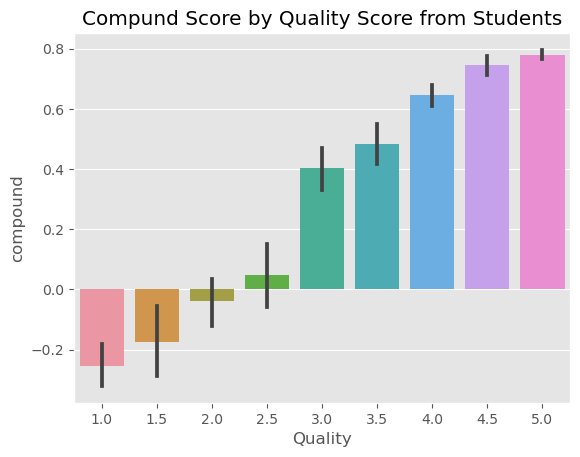

In [15]:
ax = sns.barplot(data=vaders, x='Quality', y='compound', order=sorted(vaders['Quality'].unique()))
ax.set_title('Compund Score by Quality Score from Students')
plt.show()

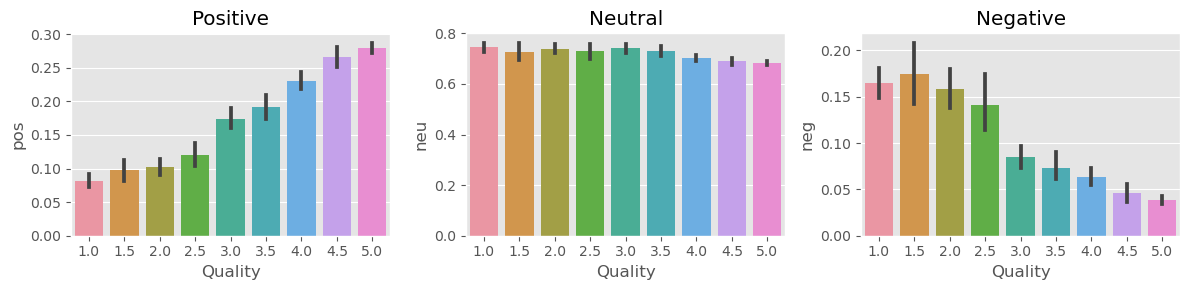

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Quality', y='pos',order=sorted(vaders['Quality'].unique()), ax=axs[0])
sns.barplot(data=vaders, x='Quality', y='neu',order=sorted(vaders['Quality'].unique()), ax=axs[1])
sns.barplot(data=vaders, x='Quality', y='neg',order=sorted(vaders['Quality'].unique()), ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Roberta Pretrained Model

1) Use a model trained of a large corpus of data.
2) Transformer model accounts for the words but also the context related to other words.

In [17]:
!pip install transformers
!pip install torch
!pip install scipy
import torch
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [19]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Took her freshman class.  Very interesting. papers were the only grade and shes a fairly good grader.  I would take her if you have the chance.  work load is reasonable


{'neg': 0.0, 'neu': 0.76, 'pos': 0.24, 'compound': 0.7841}

In [20]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0020005654, 'roberta_neu': 0.016764786, 'roberta_pos': 0.9812346}


In [21]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [22]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Comment']
        myid = row['S.no']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/3374 [00:00<?, ?it/s]

In [23]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'S.no'})
results_df = results_df.merge(df, how='left')

In [24]:
results_df

,S.no,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,course_id,professor,department,Quality,Difficulty,Comment
0,1,0.039,0.761,0.199,0.9069,0.005173,0.026136,0.968691,FHS010,James Nichols,Government department,5.0,2.0,Professor Nichols is super nice and very whole...
1,2,0.000,0.905,0.095,0.2724,0.251181,0.499247,0.249571,FHS010,James Nichols,Government department,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,3,0.136,0.452,0.412,0.7088,0.007075,0.033313,0.959613,POLPHILOSOPHY,James Nichols,Government department,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,4,0.000,0.684,0.316,0.9588,0.001860,0.015117,0.983023,FHS010,James Nichols,Government department,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5,0.000,0.512,0.488,0.8166,0.001472,0.016394,0.982134,FHS10,James Nichols,Government department,5.0,1.0,Good Professor. Really nice and encouraging te...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,3370,0.147,0.632,0.221,0.3400,0.915222,0.076229,0.008548,ECON101,Meric Keskinel,Economics department,1.0,4.0,don't take this call unless you love memorizin...
3370,3371,0.068,0.759,0.173,0.5984,0.086037,0.262599,0.651364,ECON50,Meric Keskinel,Economics department,4.0,2.0,Really funny guy. He gives ridiculous (but app...
3371,3372,0.121,0.713,0.166,0.3599,0.868505,0.117463,0.014032,ECON50,Meric Keskinel,Economics department,2.5,4.0,Only teaches from powerpoints and gives tons o...
3372,3373,0.076,0.751,0.172,0.6227,0.037378,0.142137,0.820485,ECON50,Meric Keskinel,Economics department,4.5,2.0,Awesome prof. Gives out homework and short ess...


## Comparing Scores between models

In [25]:
results_df.columns

Index(['S.no', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'course_id', 'professor',
       'department', 'Quality', 'Difficulty', 'Comment'],
      dtype='object')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

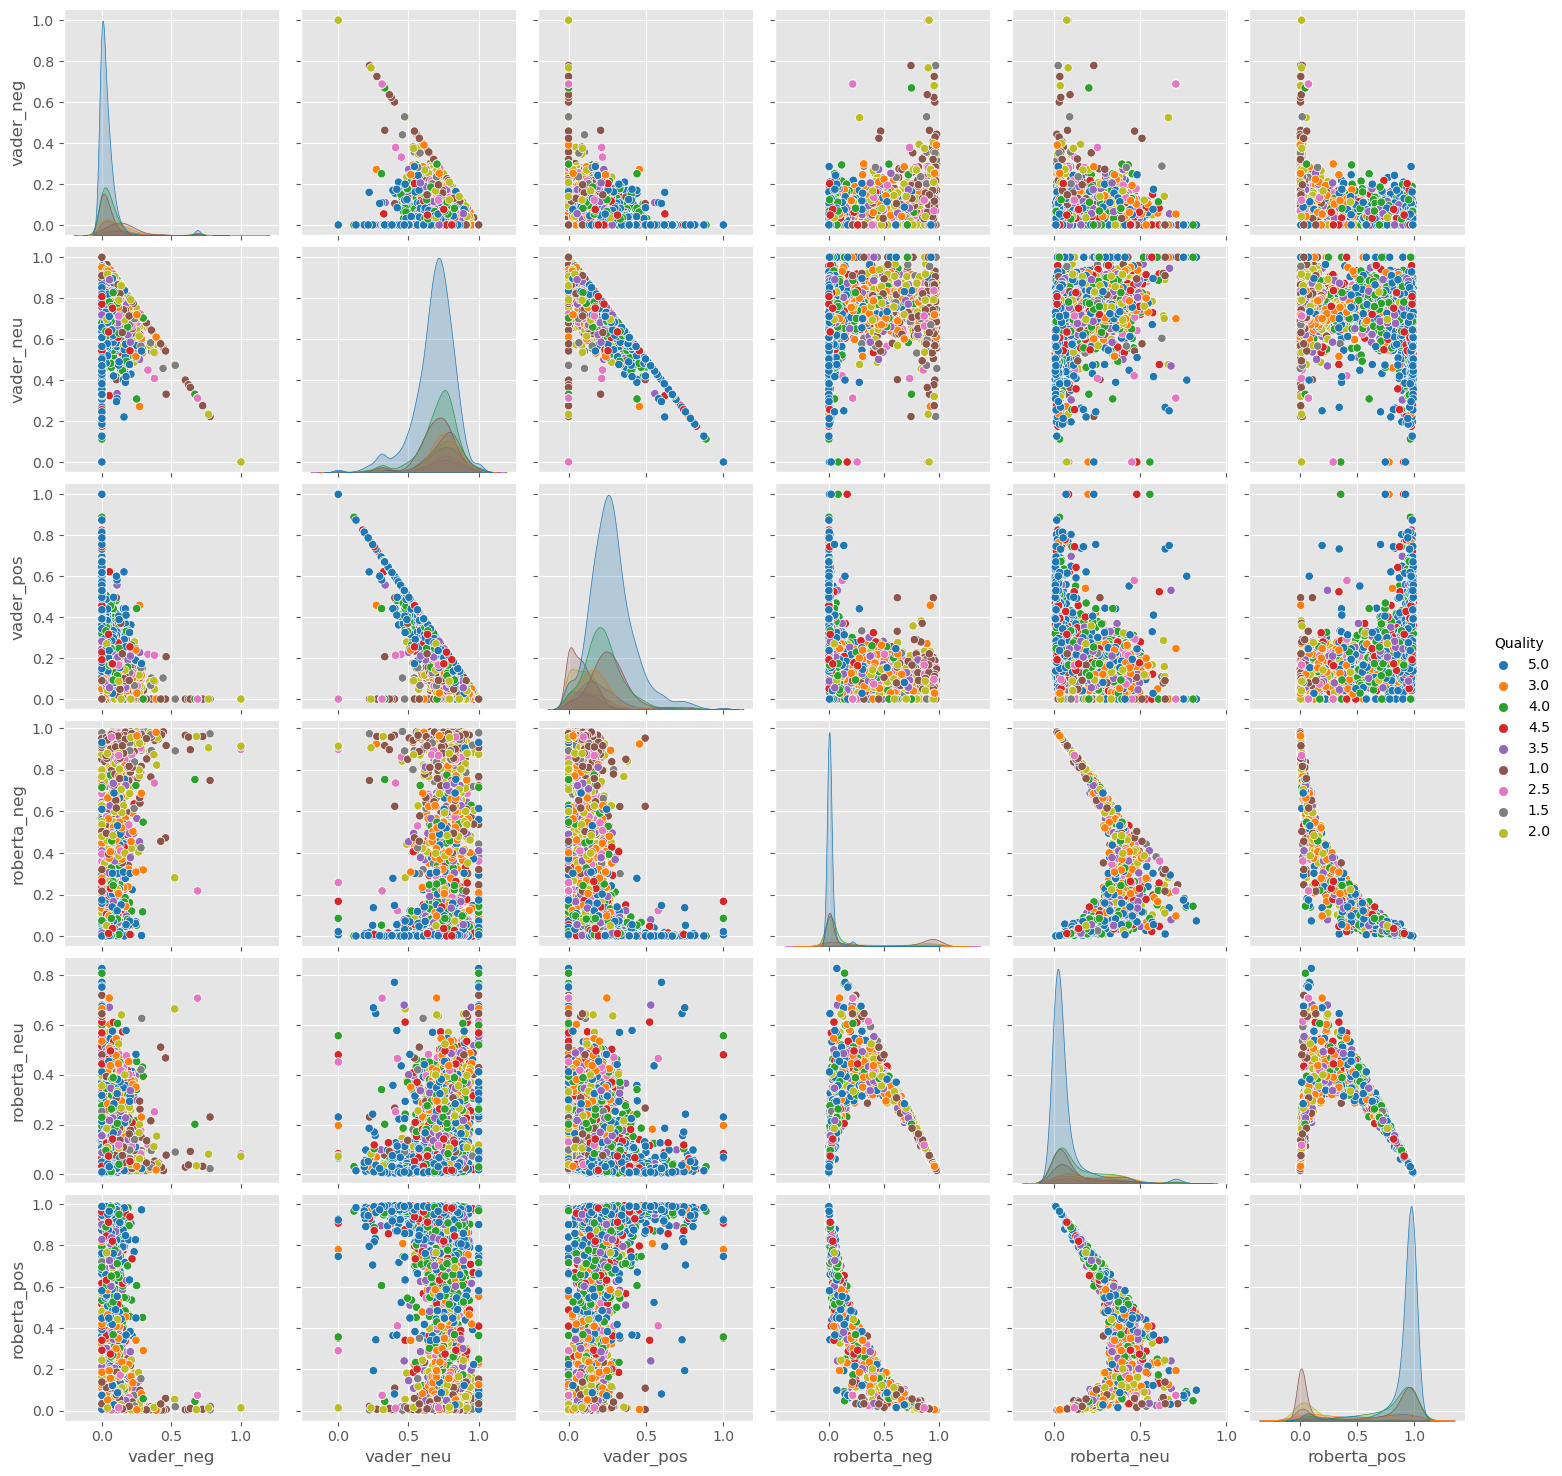

In [26]:

sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Quality',
            palette='tab10')
plt.show()

### Reviewing Examples
Lets look at some examples where the model scoring and review score differ the most.

#### Positive Sentiment 1-star review

In [27]:
results_df['Quality'] = results_df['Quality'].astype(float)
results_df.query('Quality == 1.0') \
    .sort_values('roberta_pos', ascending=False)['Comment'].values[0]

'as a person hes probably the funniest professor youll have at cmc and now that im out of the class i love the guy but hes too smart to be teaching entry level classes and is hard to understand a lot, also goes off topic a lot'

In [28]:
results_df.query('Quality == 1.0') \
    .sort_values('vader_pos', ascending=False)['Comment'].values[0]

"Incredibly boring. Acts like she's falling asleep. Seems stoned. But her class is super easy. Easiest A at CMC."

#### Negative Sentiment 5-star review

In [29]:
results_df.query('Quality == 5.0') \
    .sort_values('roberta_neg', ascending=False)['Comment'].values[0]

'i hate this guy honestly. but because i forgot how numbers work imma gibe dis cuh a five point zero ong bluh'

In [30]:
results_df.query('Quality == 5.0') \
    .sort_values('vader_neg', ascending=False)['Comment'].values[0]

'No Comments'

## The Transformers Pipeline

In [31]:
!pip install transformers  

from transformers import pipeline  

# Load sentiment analysis pipeline  
sent_pipeline = pipeline("sentiment-analysis")  


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [32]:
sent_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9997110962867737}]

In [33]:
results_df.to_csv('sentiment_score.csv', index=False)